In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [9]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

In [10]:
pd.read_csv('cnn1d/predict.csv', index_col=0)

,0,1,2,3,4,5,true
0,-24.943642,-14.376371,-30.270120,-34.804478,3.497355,8.651757,5
1,-41.976780,-51.831050,31.597225,0.572858,-34.029915,-22.983843,2
2,-10.403299,-20.507471,-35.264004,-31.831710,11.764874,-4.416489,4
3,-5.945934,22.957941,-33.201534,-32.098297,-3.378157,-19.997862,1
4,-14.173546,-47.217030,1.452709,18.719597,-17.833082,-30.701788,3
...,...,...,...,...,...,...,...
8232,-28.623846,-12.533557,-35.611202,-48.531260,-17.438105,27.528528,5
8233,-8.888363,29.173090,-50.077850,-46.275227,-8.637765,-20.413746,1
8234,-16.864460,-31.371332,8.489798,21.025810,-16.934925,-15.883045,3
8235,-41.362280,-50.563858,32.829685,-19.339918,-31.942530,-29.716520,2


In [11]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
# load data
cnn1d_predict = pd.read_csv('cnn1d/predict.csv', index_col=0).drop('true', axis=1)
convbbt_predict = pd.read_csv('convbbt/predict.csv', index_col=0).drop('true', axis=1)
true = pd.read_csv('cnn1d/predict.csv')['true'].map(lambda x: LABELS[x])
# to probability
convbbt_predict = convbbt_predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
convbbt_predict = convbbt_predict.apply(lambda x: x / x.sum(), axis=1)
# to label
cnn1d_predict_label = cnn1d_predict.idxmax(axis=1).map(lambda x: LABELS[int(x)])
convbbt_predict_label = convbbt_predict.idxmax(axis=1).map(lambda x: LABELS[int(x)])
# set columns
cnn1d_predict.columns = LABELS
convbbt_predict.columns = LABELS

In [12]:
print(f'cnn1d and convbbt both correct {len(true.loc[(cnn1d_predict_label==true)&(convbbt_predict_label==true)])}')
print(f'cnn1d correct and convbbt wrong {len(true.loc[(cnn1d_predict_label==true)&(convbbt_predict_label!=true)])}')
print(f'cnn1d wrong and convbbt correct {len(true.loc[(cnn1d_predict_label!=true)&(convbbt_predict_label==true)])}')
print(f'cnn1d and convbbt both wrong {len(true.loc[(cnn1d_predict_label!=true)&(convbbt_predict_label!=true)])}')

cnn1d and convbbt both correct 7597
cnn1d correct and convbbt wrong 272
cnn1d wrong and convbbt correct 245
cnn1d and convbbt both wrong 123


thredshold: 0.4
length of convbbt predict: 7427

cnn1d accuracy: 0.9553235401238315
convbbt accuracy: 0.9520456476872647

ensamble calc_accuracy: 0.9640645866213428


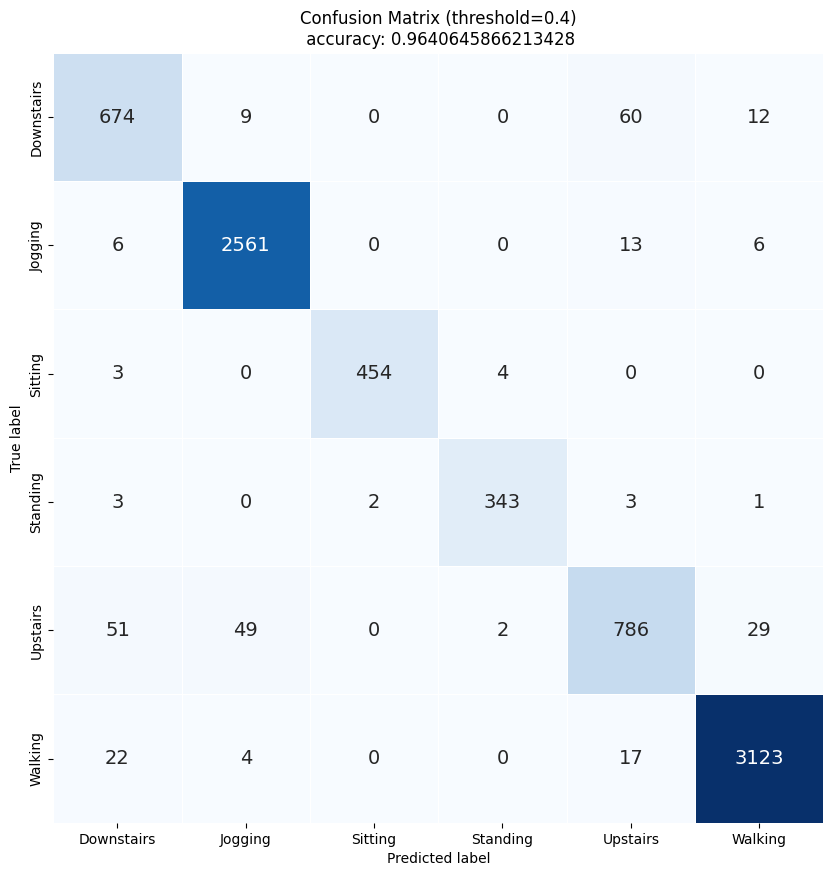

In [13]:
threshold = 0.4
print(f'thredshold: {threshold}')
print(f"length of convbbt predict: {sum(convbbt_predict.max(axis=1) > threshold)}\n")


print(f'cnn1d accuracy: {calc_accuracy(pd.DataFrame({"true_label": true, "predict_label": cnn1d_predict_label}))}')
print(f'convbbt accuracy: {calc_accuracy(pd.DataFrame({"true_label": true, "predict_label": convbbt_predict_label}))}')

ensamble_predict = convbbt_predict_label.copy()
ensamble_predict.loc[convbbt_predict.max(axis=1) < threshold] = cnn1d_predict_label.loc[convbbt_predict.max(axis=1) < threshold]

print()
print(f"ensamble calc_accuracy: {calc_accuracy(pd.DataFrame({'true_label': true, 'predict_label': ensamble_predict}))}")

cm = confusion_matrix(true, ensamble_predict, labels=LABELS)
cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 14},
    square=True,
)
plt.title(f"Confusion Matrix (threshold={threshold})\n accuracy: {calc_accuracy(pd.DataFrame({'true_label': true, 'predict_label': ensamble_predict}))}")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig(f'ensamble_confusion_matrix_threshold{threshold}.png')

drop : 810
cnn1d predict : 3005
processd ensamble calc_accuracy: 0.9783223374175306


Text(0.5, 80.7222222222222, 'Predicted label')

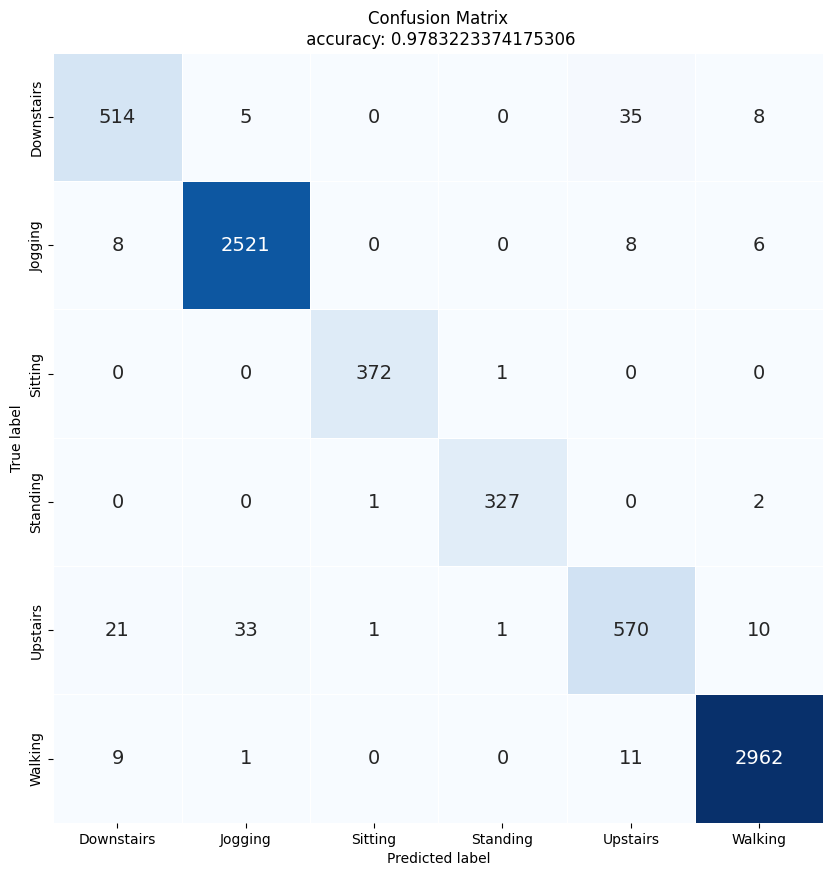

In [14]:
drop_threshold = 0.4
cnn1d_threshold = 0.5

drop_index = convbbt_predict.max(axis=1) < drop_threshold
cnn1d_predict_index = convbbt_predict.max(axis=1) < cnn1d_threshold
print(f'drop : {sum(drop_index)}')
print(f'cnn1d predict : {sum(cnn1d_predict_index)}')
processd_true = true.loc[~drop_index]
processd_ensamble_predict = convbbt_predict_label.loc[~drop_index].copy()
processd_ensamble_predict.loc[cnn1d_predict_index] = cnn1d_predict_label.loc[cnn1d_predict_index]

print(f"processd ensamble calc_accuracy: {calc_accuracy(pd.DataFrame({'true_label': processd_true, 'predict_label': processd_ensamble_predict}))}")

cm = confusion_matrix(processd_true, processd_ensamble_predict, labels=LABELS)
cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 14},
    square=True,
)
plt.title(f"Confusion Matrix\n accuracy: {calc_accuracy(pd.DataFrame({'true_label': processd_true, 'predict_label': processd_ensamble_predict}))}")
plt.ylabel("True label")
plt.xlabel("Predicted label")